In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import tree
%matplotlib inline

<html>
    <body>
        <hr>
        <h1>The Data Analysis</h1>
        <hr>
        <p>In this Part we are going to clean and analyse our data.</p>
        <p>Then we are going to build models and see which one is the best fit for our dataset.</p>
    </body>
</html>

<html>
    <body>
        <hr>
        <h>Lets see the data</h>
        <hr>
        <p>The whole dataset contains 115530 fields, and as we can see in the info they are all objects.</p>
    </body>
</html>

In [2]:
df = pd.read_csv('Crawled_Data.csv')

In [3]:
df

,Airline,Date,Source_Airport,Destination_Airport,Route,Departure_Time,Arrival_Time,Duration,Stops_Number,Price
0,Ryanair,2022-02-06,TLV,FCO,NaN,19:40,22:25,3h 45m,nonstop,143
1,Ryanair,2022-02-06,TLV,FCO,NaN,19:40,22:25,3h 45m,nonstop,181
2,Pegasus Airlines,2022-02-06,TLV,FCO,SAW,5:30,11:30,7h 00m,1 stop,250
3,Wizz Air,2022-02-06,TLV,FCO,OTP,9:25,15:00,6h 35m,1 stop,281
4,easyJet,2022-02-06,TLV,NAP,BER,13:10,21:45,9h 35m,1 stop,370
...,...,...,...,...,...,...,...,...,...,...
11548,Pegasus Airlines,2022-05-12,TLV,GVA,SAW,05:10,13:15,9h 05m,1 stop,481
11549,Austrian Airlines,2022-05-12,TLV,ZRH,VIE,06:15,14:20,9h 05m,1 stop,"1,549"
11550,Brussels Airlines,2022-05-12,TLV,GVA,"FRA, BRU",08:00,16:20,9h 20m,2 stops,"1,622"
11551,SWISS,2022-05-12,TLV,GVA,"ZRH, FRA",04:50,13:20,9h 30m,2 stops,"1,721"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11553 entries, 0 to 11552
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Airline              11553 non-null  object
 1   Date                 11553 non-null  object
 2   Source_Airport       11553 non-null  object
 3   Destination_Airport  11553 non-null  object
 4   Route                10100 non-null  object
 5   Departure_Time       11553 non-null  object
 6   Arrival_Time         11553 non-null  object
 7   Duration             11553 non-null  object
 8   Stops_Number         11553 non-null  object
 9   Price                11553 non-null  object
dtypes: object(10)
memory usage: 902.7+ KB


<html>
    <body>
        <hr>
        <h>Dropping Duplicates</h>
        <hr>
        <p>In the crawling proccess, we purchased the data from different ticket categories (Cheapest/Best/Quickest). It makes a big sense for having many duplicates because of the overlap between some flights.</p>
    </body>
</html>

In [5]:
df.drop_duplicates(inplace = True)

In [6]:
print(f'Shape is: {df.shape}\n')
print(f'Amount is: {df.shape[0]*df.shape[1]}')

Shape is: (6133, 10)

Amount is: 61330


<html>
    <body>
        <hr>
        <p> Well, it's significantly reduced our data, but we still have a fair amount of data </p>
        <hr>
        <p>Now, we will convert the data into a form that will help us analyze and understand the data</p>
        <p> In order to discretize the price column, we will convert it to int and round the data to the nearest hundredth. Thus when we predict a price, we predict the price category to which it belongs. For example, between 200 and 300 NIS </p>
    </body>
</html>

In [7]:
def Price_To_Int(df):
    df2 = df.copy()
    df2['Price'] = df2['Price'].apply(lambda x:int(x.replace(',','')))
    df2 = df2.round({'Price':-2})
    return df2

In [8]:
df = Price_To_Int(df)

In [9]:
df['Price'].unique()

array([ 100,  200,  300,  400,  500,  600,  800, 1000, 1400, 1500, 2400,
          0,  700,  900, 1300, 3100, 1100, 1200, 3000, 1600, 2100, 1700,
       1900, 2000, 2300, 2600, 5300, 3400, 3300, 5700, 6300, 2200, 4900,
       5400, 1800, 3800, 2500, 2700, 3500, 5200, 3900, 4000, 5000, 9400,
       3600], dtype=int64)

<html>
    <body>
        <hr>
        <p> Now, we will split the date by day and month. The year is not critical as we have only acquired data from 2022 </p>
    </body>
</html>

In [10]:
df['Day'] = pd.to_datetime(df['Date'],format='%Y-%m-%d').dt.day
df['Month'] = pd.to_datetime(df['Date'],format='%Y-%m-%d').dt.month
df.drop('Date',axis=1,inplace=True)

<html>
    <body>
        <hr>
        <p>Now we split the time form by hours and minuts</p>
    </body>
</html>

In [11]:
df['Dep_hour'] = pd.to_datetime(df.Departure_Time).dt.hour
df['Dep_min'] = pd.to_datetime(df.Departure_Time).dt.minute
df.drop('Departure_Time',axis=1,inplace=True)

In [12]:
df['Arr_hour'] = pd.to_datetime(df.Arrival_Time).dt.hour
df['Arr_min'] = pd.to_datetime(df.Arrival_Time).dt.minute
df.drop('Arrival_Time',axis=1,inplace=True)

In [13]:
df.head()

,Airline,Source_Airport,Destination_Airport,Route,Duration,Stops_Number,Price,Day,Month,Dep_hour,Dep_min,Arr_hour,Arr_min
0,Ryanair,TLV,FCO,NaN,3h 45m,nonstop,100,6,2,19,40,22,25
1,Ryanair,TLV,FCO,NaN,3h 45m,nonstop,200,6,2,19,40,22,25
2,Pegasus Airlines,TLV,FCO,SAW,7h 00m,1 stop,200,6,2,5,30,11,30
3,Wizz Air,TLV,FCO,OTP,6h 35m,1 stop,300,6,2,9,25,15,0
4,easyJet,TLV,NAP,BER,9h 35m,1 stop,400,6,2,13,10,21,45


<html>
    <body>
        <hr>
       <p> Currently the "Duration" column contains values ​​of the form Xh Ym and we want to split the column into hours and minutes. We will use regex to do this. </p>
    </body>
</html>

In [14]:
def Get_Duration(duration):
    pattern = '(.*)h (.*)m'
    hours = re.findall(pattern,duration)[0][0]
    mins = re.findall(pattern,duration)[0][1]
    return hours,mins

In [15]:
def Split_Duration(df):
    df2 = df.copy()
    df2['Duration_Hours'] = df2['Duration'].apply(lambda x:int(Get_Duration(x)[0]))
    df2['Duration_Minutes'] = df2['Duration'].apply(lambda x:int(Get_Duration(x)[0]))
    df2.drop(['Duration'], inplace=True, axis=1)
    return df2

In [16]:
df = Split_Duration(df)

In [17]:
df.head()

,Airline,Source_Airport,Destination_Airport,Route,Stops_Number,Price,Day,Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_Hours,Duration_Minutes
0,Ryanair,TLV,FCO,NaN,nonstop,100,6,2,19,40,22,25,3,3
1,Ryanair,TLV,FCO,NaN,nonstop,200,6,2,19,40,22,25,3,3
2,Pegasus Airlines,TLV,FCO,SAW,1 stop,200,6,2,5,30,11,30,7,7
3,Wizz Air,TLV,FCO,OTP,1 stop,300,6,2,9,25,15,0,6,6
4,easyJet,TLV,NAP,BER,1 stop,400,6,2,13,10,21,45,9,9


In [18]:
df['Stops_Number'].unique()

array(['nonstop', '1 stop', '2 stops', '3 stops'], dtype=object)

<html>
    <body>
        <hr>
           <p> The flights we purchased have direct flights, one-stop flights, two-stop flights and 3-stop flights. We will convert the strings to int which represents the number of stops: 0-3 </p>
    </body>
</html>

In [19]:
df.replace({'nonstop':0,'1 stop':1,'2 stops':2,'3 stops':3}, inplace=True)

<html>
    <body>
        <hr>
           <p> now we convert the rest of our data into numerical type </p>
    </body>
</html>

In [20]:
def Cols_Into_Int(df, cols):
    l = []
    df2 = df.copy()
    for col in cols:
        l = list(df2[col])
        unique_list = np.unique(l)
        dic = {}
        for i,x in enumerate(unique_list):
            dic[x] = i+2
        df2.replace(dic, inplace=True)
    return df2

In [21]:
df = Cols_Into_Int(df,['Airline','Source_Airport','Destination_Airport'])

<html>
    <body>
        <hr>
          <p> we drop non critical columns </p>
    </body>
</html>

In [22]:
df.drop(['Dep_min','Arr_min','Duration_Minutes','Route'], axis=1,inplace=True)

In [23]:
df

,Airline,Source_Airport,Destination_Airport,Stops_Number,Price,Day,Month,Dep_hour,Arr_hour,Duration_Hours
0,28,3,12,0,100,6,2,19,22,3
1,28,3,12,0,200,6,2,19,22,3
2,25,3,12,1,200,6,2,5,11,7
3,40,3,12,1,300,6,2,9,15,6
4,42,3,21,1,400,6,2,13,21,9
...,...,...,...,...,...,...,...,...,...,...
11523,23,3,14,1,1600,12,5,8,14,7
11525,20,3,29,1,2100,12,5,4,11,7
11541,30,3,14,2,1700,12,5,4,12,8
11550,11,3,14,2,1600,12,5,8,16,9


In [24]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6133 entries, 0 to 11551
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Airline              6133 non-null   int64
 1   Source_Airport       6133 non-null   int64
 2   Destination_Airport  6133 non-null   int64
 3   Stops_Number         6133 non-null   int64
 4   Price                6133 non-null   int64
 5   Day                  6133 non-null   int64
 6   Month                6133 non-null   int64
 7   Dep_hour             6133 non-null   int64
 8   Arr_hour             6133 non-null   int64
 9   Duration_Hours       6133 non-null   int64
dtypes: int64(10)
memory usage: 527.1 KB


<html>
    <body>
        <hr>
        <h>IQR</h>
        <hr>
        <p> Now, that all of our data is type int, we continue to outliers detection </p> 
          <p> As we can see, we have a lot of outliers, and the range of them is different per country. We use IQR to reduce them</p>
        <p>Lets see some graphs</p>
    </body>
</html>

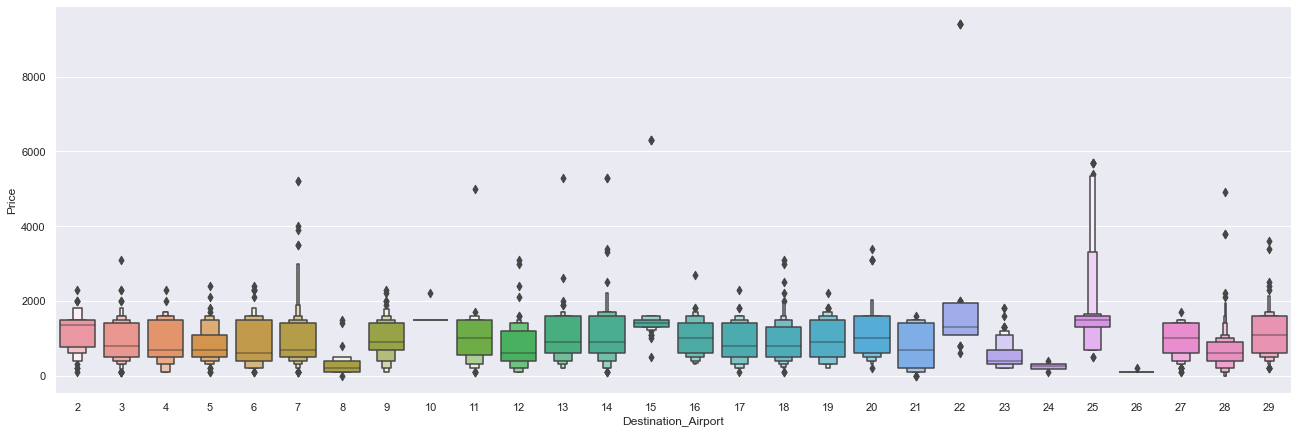

In [25]:
sns.set()
sns.catplot(y = "Price", x = "Destination_Airport", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

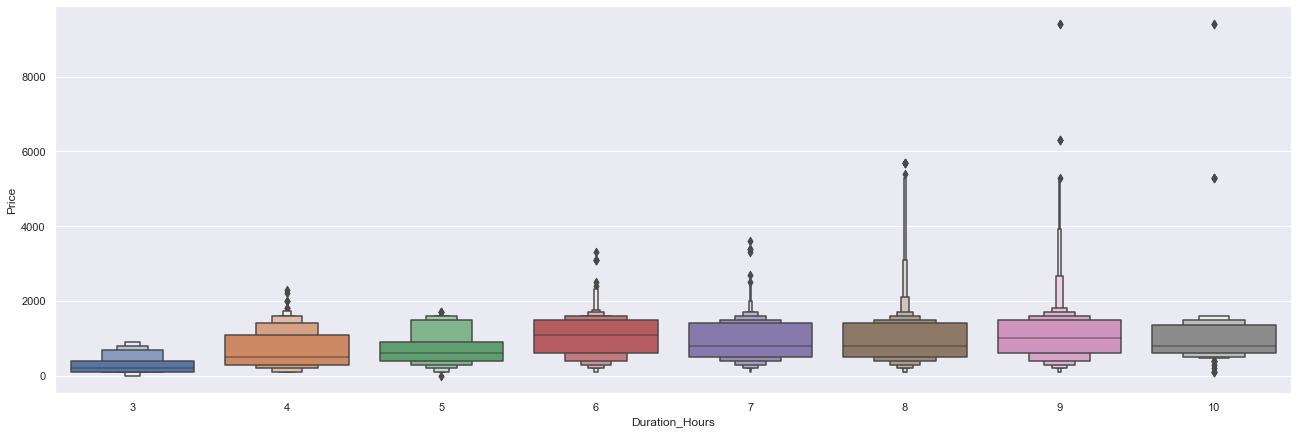

In [26]:
sns.set()
sns.catplot(y = "Price", x = "Duration_Hours", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

<html>
    <body>
        <hr>
          <p> as we can see, we have a lot of outliers, and the range of them is different per country. We use IQR per country to reduce them</p>
    </body>
</html>

In [27]:
def Outlier_Detection_IQR(df, cols):
    df2 = df.copy()
    for col in cols:
        for airport in df2['Destination_Airport'].unique():
            Q1 = np.percentile(df2[df2['Destination_Airport']==airport][col], 25)
            Q3 = np.percentile(df2[df2['Destination_Airport']==airport][col], 75)
            IQR = Q3 - Q1
            IQR_range = 1.5 * IQR
            df2.loc[(df2['Destination_Airport']==airport)&((df2[col] < Q1 - IQR_range) | (df2[col] > Q3 + IQR_range)), [col]] = np.nan
    return df2

In [28]:
df = Outlier_Detection_IQR(df, ['Price','Duration_Hours'])
df.dropna(inplace=True)

<html>
    <body>
        <hr>
        <p>Lets see graphs, After the IQR</p>
    </body>
</html>

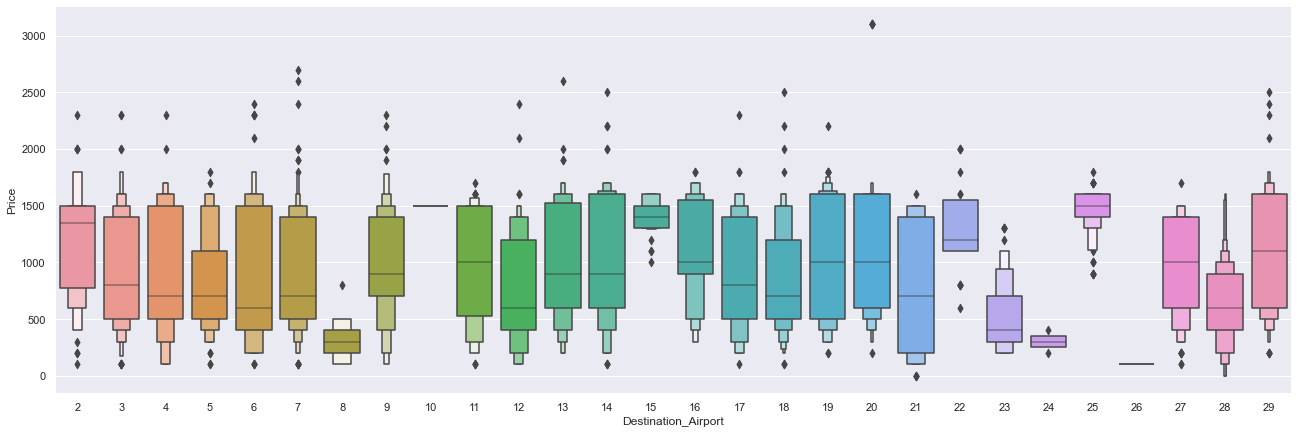

In [29]:
sns.set()
sns.catplot(y = "Price", x = "Destination_Airport", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

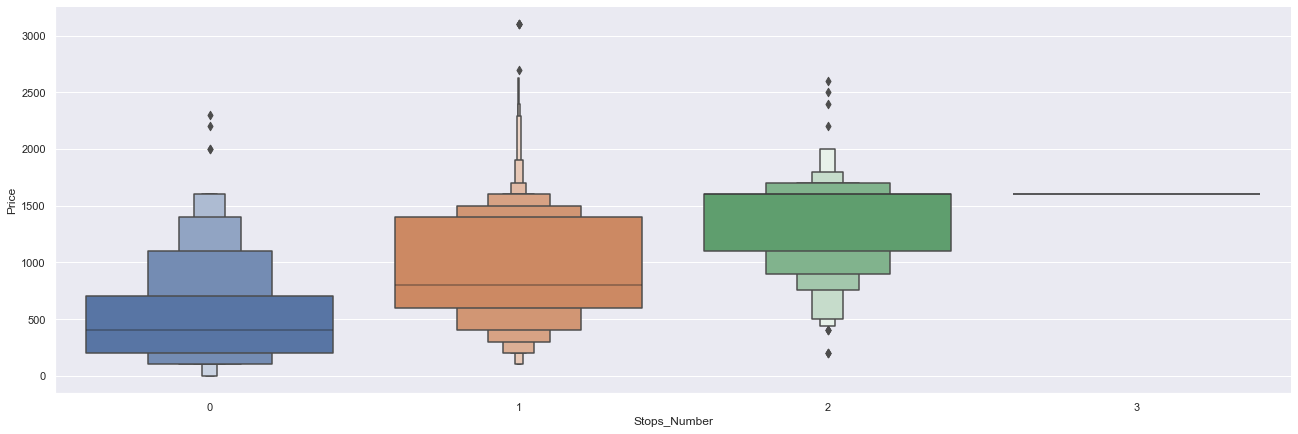

In [30]:
sns.set()
sns.catplot(y = "Price", x = "Stops_Number", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

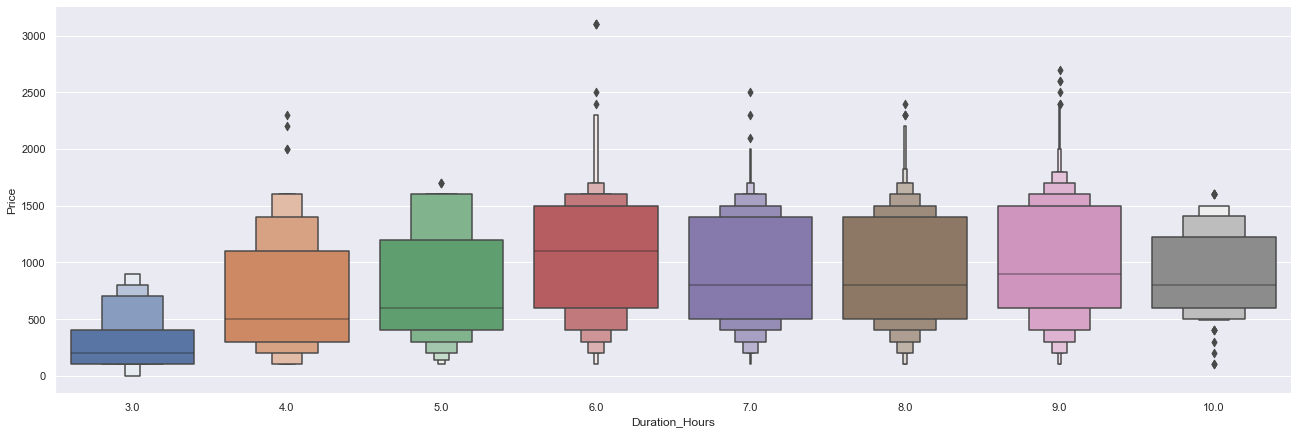

In [31]:
sns.set()
sns.catplot(y = "Price", x = "Duration_Hours", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

<AxesSubplot:ylabel='Destination_Airport'>

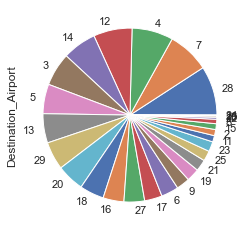

In [32]:
df['Destination_Airport'].value_counts().plot(kind='pie')

<AxesSubplot:>

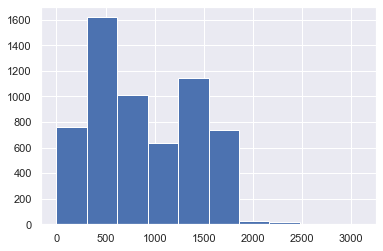

In [33]:
df['Price'].hist()

<html>
    <body>
        <hr>
        <h>Model Building And data Creation</h>
        <hr>
        <p> After seeing some graphs that helped us better understand the data and their distribution, we will divide our data into a training and test group and start building the model. </p>
    </body>
</html>

In [34]:
def get_highly_correlated_cols(df):
    correlations =[]
    tuple_arr = []
    d = df.shape[1]
    df2 = df.corr(method='pearson')
    for i,col in enumerate(df2.columns):
        for j,col2 in enumerate(df2.columns):
            if i<j and df2.iloc[i,j]>=0.5:
                correlations.append(df2.iloc[i,j])
                tuple_arr.append((col,col2))           
    return correlations, tuple_arr

In [35]:
c,t = get_highly_correlated_cols(df)
for i in range(len(c)):
    print(f'{t[i]},\t\t {c[i]}')

('Stops_Number', 'Duration_Hours'),		 0.6776227719161357
('Dep_hour', 'Arr_hour'),		 0.8758892055550468


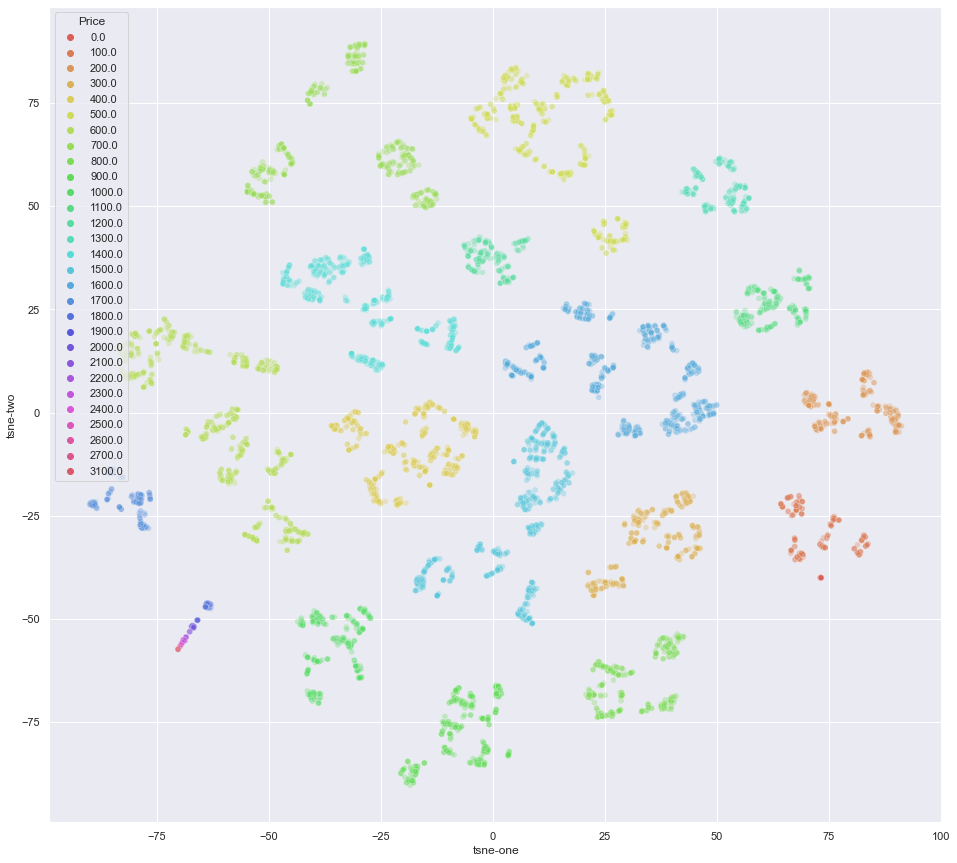

In [36]:
tsne = TSNE(n_components = 2)
tsne_result = tsne.fit_transform(df.values)
df['tsne-one'] = tsne_result[:,0]
df['tsne-two'] = tsne_result[:,1]
plt.figure(figsize=(16,15))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue=df['Price'],
    palette=sns.color_palette("hls", len(df.Price.unique())),
    data=df,
    legend="full",
    alpha=0.3)
df.drop('tsne-one', inplace=True, axis=1)
df.drop('tsne-two', inplace=True, axis=1)

In [37]:
def Plot_Graph(y_test, y_predict):
    number_of_observations=50
    x_ax = range(len(y_test[:number_of_observations]))
    plt.plot(x_ax,y_test[:number_of_observations], label='original')
    plt.plot(x_ax,y_predict[:number_of_observations], label='predicted')
    plt.title('Flight_Prediction')
    plt.xlabel('Observation Number')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [38]:
def Train_Test_Score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    y_predict = model.predict(X_test).round(-2)
    Plot_Graph(y_test, y_predict)
    print('Train score :',train_score)
    print('Test score :',test_score)
    data = pd.DataFrame({'Price_predicted':y_predict,
                      'Price_Actual':y_test})
    return data, model

In [39]:
X = df.drop('Price',axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [40]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

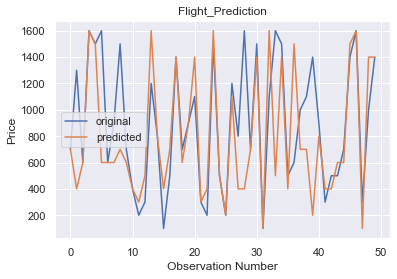

Train score : 0.5566741237882178
Test score : 0.3389261744966443


,Price_predicted,Price_Actual
2478,700.0,700.0
1179,400.0,1300.0
11448,600.0,600.0
5425,1600.0,1600.0
2809,1500.0,1500.0
...,...,...
5349,700.0,800.0
354,1700.0,1500.0
3559,300.0,400.0
2391,1700.0,1700.0


In [41]:
from sklearn.neighbors import KNeighborsClassifier
data, model = Train_Test_Score(KNeighborsClassifier(),X_train, X_test, y_train, y_test)
data

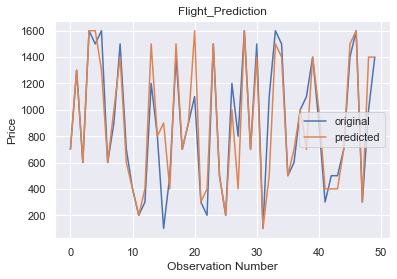

Train score : 0.883668903803132
Test score : 0.4563758389261745


,Price_predicted,Price_Actual
2478,700.0,700.0
1179,1300.0,1300.0
11448,600.0,600.0
5425,1600.0,1600.0
2809,1600.0,1500.0
...,...,...
5349,800.0,800.0
354,1400.0,1500.0
3559,300.0,400.0
2391,1700.0,1700.0


In [42]:
from sklearn.ensemble import RandomForestClassifier
data, model = Train_Test_Score(RandomForestClassifier(),X_train, X_test, y_train, y_test)
data

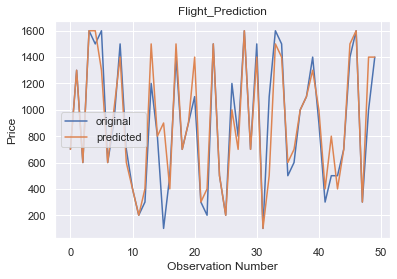

Train score : 0.883668903803132
Test score : 0.43791946308724833


,Price_predicted,Price_Actual
2478,700.0,700.0
1179,1300.0,1300.0
11448,600.0,600.0
5425,1600.0,1600.0
2809,1600.0,1500.0
...,...,...
5349,800.0,800.0
354,1400.0,1500.0
3559,300.0,400.0
2391,1700.0,1700.0


In [43]:
from sklearn.tree import DecisionTreeClassifier
data, model = Train_Test_Score(DecisionTreeClassifier(),X_train, X_test, y_train, y_test)
data

In [ ]:
from sklearn.ensemble import RandomForestRegressor
data, model = Train_Test_Score(RandomForestRegressor(n_estimators = 1009),X_train, X_test, y_train, y_test)
data

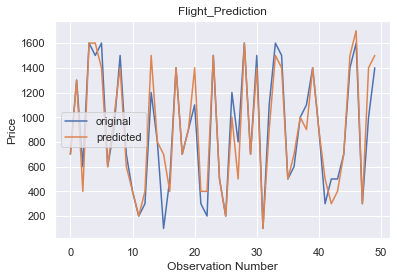

Train score : 0.9880169965181316
Test score : 0.8627126111407808


,Price_predicted,Price_Actual
2478,700.0,700.0
1179,1300.0,1300.0
11448,400.0,600.0
5425,1600.0,1600.0
2809,1600.0,1500.0
...,...,...
5349,900.0,800.0
354,1400.0,1500.0
3559,300.0,400.0
2391,1700.0,1700.0


In [45]:
from sklearn.ensemble import ExtraTreesRegressor
data, model = Train_Test_Score(ExtraTreesRegressor(),X_train, X_test, y_train, y_test)
data